# Spaceship Titanic dataset (Kaggle)

This is a Kaggle competition and can be found [here](https://www.kaggle.com/competitions/spaceship-titanic/overview).

In this notebook I use `Gradient Boosting` implemented in `XGBoost` to predict `Transported`.

Best test `accuracy=0.82`.
The results of the random searches are on [wandb](https://wandb.ai/daniele-didino/spaceship_titanic)

The models implemented here use the following predictors:

- `Age`: The age of the passenger. [`numeric`]
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities. [`numeric`]
- `HomePlanet`: The planet the passenger departed from, typically their planet of permanent residence. [`categorical`]
- `CryoSleep`: Indicates whether the passenger was put into suspended animation. Passengers in cryosleep are confined to their cabins. [`categorical`]
- `Destination`: The planet the passenger will be debarking to. [`categorical`]
- `VIP`: Whether the passenger has paid for special VIP service during the voyage. [`categorical`]
- `group_size_bin`: The size of the group the passenger is travellin with (category: "g1", "g2", "g3", "g4more", for 1, 2, 3 or 4-or-more, respectively). [`categorical`]
- `deck`: The deck information from **Cabin** column. [`categorical`]
- `side`: The side information from **Cabin** column. [`categorical`]

\
Label:
- `Transported`: Whether the passenger was transported to another dimension. [`binary`]

# Load libraries

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
import wandb

np.random.seed(123)

# Load data

In [2]:
# Load the dataset
def load_ds(path: Path, filename: str) -> pd.DataFrame:
    """Read the dataset csv file as a pandas dataframe."""
    return pd.read_csv(path / filename)

# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_train.csv"
X_y_train = load_ds(dataset_path, filename)
print(f"Shape: {X_y_train.shape}")

Shape: (6954, 14)


In [3]:
print(X_y_train.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [4]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6789 non-null   object 
 2   CryoSleep     6782 non-null   object 
 3   Cabin         6795 non-null   object 
 4   Destination   6805 non-null   object 
 5   Age           6809 non-null   float64
 6   VIP           6800 non-null   object 
 7   RoomService   6801 non-null   float64
 8   FoodCourt     6796 non-null   float64
 9   ShoppingMall  6788 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6809 non-null   float64
 12  Name          6786 non-null   object 
 13  Transported   6954 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 713.2+ KB


In [5]:
X_y_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,7527_01,Earth,False,F/1561/P,TRAPPIST-1e,18.0,False,0.0,732.0,2.0,13.0,47.0,Elle Flowensley,True
1,7083_01,Europa,True,C/259/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,Betenar Pirejus,True
2,2755_01,Europa,True,B/85/P,55 Cancri e,36.0,False,0.0,0.0,0.0,0.0,0.0,Beneba Glousspidy,True
3,4127_01,Europa,NaN,B/130/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,NaN,Dsch Ainserfle,True
4,7972_02,Europa,False,B/260/P,TRAPPIST-1e,35.0,False,NaN,246.0,25.0,42.0,3730.0,Atinon Cattyried,False


In [6]:
print(f"shape X_y_train: {X_y_train.shape}")

shape X_y_train: (6954, 14)


In [7]:
# NOTE: "drop()" create a copy of the data original dataset
X_train = X_y_train.drop(["Transported"], axis=1)
y_train = X_y_train.loc[:, "Transported"].copy()

print(f"shape X_train: {X_train.shape}")
print(f"shape y_train: {y_train.shape}")

shape X_train: (6954, 13)
shape y_train: (6954,)


# Define functions

In [8]:
def add_metrics(dictionary, y, y_pred, mod_name):
    # dictionary: a dictionary to which the metrics are added

    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    dictionary[mod_name] = {
        "accuracy": np.round(acc, 3),
        "confusion_matrix": cm,
        "precision": np.round(precision, 3),
        "recall": np.round(recall, 3),
        "f1_score": np.round(f1, 3)
    }

    return dictionary


def print_metrics(m):
    print(f"Accuracy is {m['accuracy']:.2f}.")
    print(f"When the model claims a passenger was transported to another dimension, it is correct {m['precision']*100} % of the time (precision).")
    print(f"The model detects {m['recall']*100:.2f} % of the passengers that were transported to another dimension (recall).")
    print(f"The F1 score is {m['f1_score']*100:.2f}.")


def display_cm(cm):
    # cm: a confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def compare_models(models):
    mods_table = pd.DataFrame.from_dict(models)
    return mods_table.loc[["accuracy", "precision", "recall", "f1_score"],:]

# Define pipelines

In [9]:
# Define columns to convert
c_cat = ["HomePlanet", "Cabin", "Destination"]
c_str = ["PassengerId", "Name"]

In [10]:
# Function to convert data type & add column
def convert_df(df_in: pd.DataFrame,
               col_cat: list[str],
               col_str: list[str],
               # col_bool: list[str]
 ) -> pd.DataFrame:
    """Converts the specified columns to categorical, string or bool types."""

    df_out = df_in.copy()

    for column in col_cat:
        df_out[column] = df_out[column].astype("category")
    
    for column in col_str:
        df_out[column] = df_out[column].astype("string")

    return df_out

## CombinedAttributesAdder

Define a class that transforms and select various features.

In [11]:
# TransformerMixin: add method ".fit_transform()"
# BaseEstimator: add methods ".get_params()" and ".set_params()"
# We need 3 methods:
# 1) .fit()
# 2) .transform()
# 3) .fit_transform() (provided by "TransformerMixin")
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # avoid '*args' or "**kargs" in "__init__"
    def __init__(self):
        pass

    # fit is needed later for the pipilene
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert column type
        X = convert_df(
            df_in=X,
            col_cat=c_cat,
            col_str=c_str,
            #col_bool=c_bool,
        )

        # Add "group" and "group_n"
        X[["group", "group_n"]] = X.PassengerId.str.split("_", expand=True)

        # Add "group_size" (a column with the size of the group)
        count_group_size = (
             X
             .value_counts(["group"], sort=False)
             .rename("group_size")
             .reset_index()
        )
        X = pd.merge(X, count_group_size, how="left", on="group")

        # Add "group_size_bin"
        X.loc[:, "group_size_bin"] = np.nan
        X.loc[X.group_size == 1, "group_size_bin"] = "g1"
        X.loc[X.group_size == 2, "group_size_bin"] = "g2"
        X.loc[X.group_size == 3, "group_size_bin"] = "g3"
        X.loc[X.group_size >= 4, "group_size_bin"] = "g4more"
        X["group_size_bin"] = X["group_size_bin"].astype("category")

        # Add "deck", "num" and "side"
        X[["deck", "num", "side"]] = X.Cabin.str.split("/", expand=True)
        X["deck"] = X["deck"].astype("category")
        X["num"] = X["num"].astype("string")
        X["side"] = X["side"].astype("category")
        
        # Drop unused columns
        cols_to_drop = ['PassengerId', 'Cabin', 'Name', 'group',
                        'group_n', 'group_size', 'num']
        X.drop(columns=cols_to_drop, inplace=True)

        return X

## num_pipeline

It preprocesses the numerical attributes with `SimpleImputer()` and `StandardScaler()`.

In [12]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
num_pipeline = Pipeline([
    # replace NA with mean
    ('imputer', SimpleImputer(strategy='mean')),
    # standardize the variables: z = (x - mean) / SD
    ('std_scaler', StandardScaler())])

## cat_pipeline

It preprocesses the categorical attributed with `SimpleImputer()` and `OneHotEncoder()`.

In [13]:
# All (except the last) estimators must be transformers (i.e., they
# must have a ".fit_transform()" method).
cat_pipeline = Pipeline([
    # replace NA with mode
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # apply "OneHotEncoder()"
    ('one_hot', OneHotEncoder(drop='if_binary'))])

## Combine pipelines

In [14]:
list_num_attribs = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
list_cat_attribs = ["HomePlanet", "CryoSleep", "Destination", "VIP", "group_size_bin", "deck", "side"]

In [15]:
# ColumnTransformer requires tuples with:
# - a name
# - a transformer
# - a list of names (or indices) of columns to which the transformer is applied

cols_transformer = ColumnTransformer([
    # apply "num_pipeline" to numerical columns
    ('num', num_pipeline, list_num_attribs),
    # apply "cat_pipeline" to categorical columns
    ('cat', cat_pipeline, list_cat_attribs)])

In [16]:
full_pipeline = Pipeline([
    # transform/add columns
    ('attribs_adder', CombinedAttributesAdder()),
    # Transform numerical and categorical attributes
    ("cols_transformer", cols_transformer)])

In [17]:
# print(full_pipeline.get_params().keys())
# print(full_pipeline.get_params().items())
print(full_pipeline.get_params())


{'memory': None, 'steps': [('attribs_adder', CombinedAttributesAdder()), ('cols_transformer', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP', 'group_size_bin', 'deck', 'side'])]))], 'verbose': False,

In [18]:
for i in full_pipeline.get_params().keys():
    print(i)

memory
steps
verbose
attribs_adder
cols_transformer
cols_transformer__n_jobs
cols_transformer__remainder
cols_transformer__sparse_threshold
cols_transformer__transformer_weights
cols_transformer__transformers
cols_transformer__verbose
cols_transformer__verbose_feature_names_out
cols_transformer__num
cols_transformer__cat
cols_transformer__num__memory
cols_transformer__num__steps
cols_transformer__num__verbose
cols_transformer__num__imputer
cols_transformer__num__std_scaler
cols_transformer__num__imputer__add_indicator
cols_transformer__num__imputer__copy
cols_transformer__num__imputer__fill_value
cols_transformer__num__imputer__keep_empty_features
cols_transformer__num__imputer__missing_values
cols_transformer__num__imputer__strategy
cols_transformer__num__imputer__verbose
cols_transformer__num__std_scaler__copy
cols_transformer__num__std_scaler__with_mean
cols_transformer__num__std_scaler__with_std
cols_transformer__cat__memory
cols_transformer__cat__steps
cols_transformer__cat__verbo

# Gradient Boosting

In [19]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=123
)

In [20]:
clf = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Logistic regression
    ("xgb", xgb_clf)])

In [21]:
list(clf["xgb"].get_params().keys())

['objective',
 'base_score',
 'booster',
 'callbacks',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'device',
 'early_stopping_rounds',
 'enable_categorical',
 'eval_metric',
 'feature_types',
 'gamma',
 'grow_policy',
 'importance_type',
 'interaction_constraints',
 'learning_rate',
 'max_bin',
 'max_cat_threshold',
 'max_cat_to_onehot',
 'max_delta_step',
 'max_depth',
 'max_leaves',
 'min_child_weight',
 'missing',
 'monotone_constraints',
 'multi_strategy',
 'n_estimators',
 'n_jobs',
 'num_parallel_tree',
 'random_state',
 'reg_alpha',
 'reg_lambda',
 'sampling_method',
 'scale_pos_weight',
 'subsample',
 'tree_method',
 'validate_parameters',
 'verbosity']

In [22]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

In [23]:
clf_score = dict()
y_pred = clf.predict(X_train)
clf_score = add_metrics(clf_score, y_train, y_pred, "gradient_boosting_baseline")

In [24]:
print_metrics(clf_score["gradient_boosting_baseline"])

Accuracy is 0.81.
When the model claims a passenger was transported to another dimension, it is correct 78.7 % of the time (precision).
The model detects 85.20 % of the passengers that were transported to another dimension (recall).
The F1 score is 81.80.


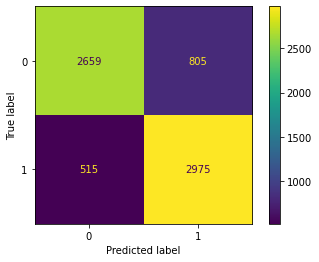

In [25]:
display_cm(clf_score["gradient_boosting_baseline"]["confusion_matrix"])

# Weights & Biases (random search)

In [26]:
parameters_dict = {
    # "n_estimators": {"values": [100]},
    # "max_depth":  {"values": [7]},
    # "learning_rate":  {"values": [0.5]},
    # "subsample":  {"values": [1.0]}, # [0.8,0.9,1.0]
    "colsample_bytree":  {"values": [1.0]},
}

parameters_dict.update({
    'n_estimators': {
        # a flat distribution of integers between min and max
        'distribution': 'int_uniform',
        'min': 500,
        'max': 1000
      },
      "max_depth": {
        # a flat distribution of integers between min and max
        'distribution': 'int_uniform',
        'min': 3,
        'max': 7
      },
      'learning_rate': {
        # a flat distribution between min and max
        'distribution': 'uniform',
        'min': 0.001,
        'max': 0.1
      },
      'subsample': {
        # a flat distribution between min and max
        'distribution': 'uniform',
        'min': 0.8,
        'max': 1
      },
    })

metric = {
    'name': 'loss',
    'goal': 'minimize'   
}

sweep_config = {
    'method': 'random'
}

sweep_config['parameters'] = parameters_dict
sweep_config['metric'] = metric

sweep_config

{'method': 'random',
 'parameters': {'colsample_bytree': {'values': [1.0]},
  'n_estimators': {'distribution': 'int_uniform', 'min': 500, 'max': 1000},
  'max_depth': {'distribution': 'int_uniform', 'min': 3, 'max': 7},
  'learning_rate': {'distribution': 'uniform', 'min': 0.001, 'max': 0.1},
  'subsample': {'distribution': 'uniform', 'min': 0.8, 'max': 1}},
 'metric': {'name': 'loss', 'goal': 'minimize'}}

In [27]:
sweep_id = wandb.sweep(sweep=sweep_config, project="spaceship_titanic")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: ws7rh2hk
Sweep URL: https://wandb.ai/daniele-didino/spaceship_titanic/sweeps/ws7rh2hk


In [28]:
def build_model(config):
    xgb_clf = XGBClassifier(
        objective='reg:squarederror',
        n_estimators= config.n_estimators,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        subsample=config.subsample,
        colsample_bytree=config.colsample_bytree,
        seed=536)
    
    pipelile_reg = Pipeline([
        ("preparation", full_pipeline),
        ("xbg", xgb_clf)])
    
    return pipelile_reg


def build_dataset(X_train, y_train):
    return X_train, y_train


def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, this config will be set by Sweep Controller
        config = wandb.config

        model = build_model(config)
        X, y = build_dataset(X_train, y_train)

        scorer = {
            "neg_log_loss": "neg_log_loss",
            "acc": "accuracy",
            "precision": "precision",
            "recall": "recall",
            "f1": "f1",
        }

        scores = cross_validate(
            model,
            X,
            y,
            cv=5,
            scoring=scorer,
            return_train_score=True)
        
        loss_train = scores["train_neg_log_loss"].mean()
        acc_train = scores["train_acc"].mean()
        precision_train = scores["train_precision"].mean()
        recall_train = scores["train_recall"].mean()
        f1_train = scores["train_f1"].mean()

        loss_val = scores["test_neg_log_loss"].mean()
        acc_val = scores["test_acc"].mean()
        precision_val = scores["test_precision"].mean()
        recall_val = scores["test_recall"].mean()
        f1_val = scores["test_f1"].mean()
        
        wandb.log({
            # Loss from valiation set
            "loss": loss_val,
            # train set
            "loss_train": loss_train,
            "acc_train": acc_train,
            "precision_train": precision_train,
            "recall_train": recall_train,
            "f1_train": f1_train,
            # validation set
            "acc_val": acc_val,
            "precision_val": precision_val,
            "recall_val": recall_val,
            "f1_val": f1_val,
        })

In [ ]:
wandb.agent(sweep_id, train, count=20)

# Final model

The best results are from models with with hyperparameters (see [Weights & Biases](https://wandb.ai/daniele-didino/spaceship_titanic)):

- `n_estimators=600`
- `max_depth=4`
- `learning_rate=0.02`
- `subsample=0.94`

In [30]:
xgb_clf_final = XGBClassifier(
    objective='binary:logistic',
    n_estimators=600,
    max_depth=4,
    learning_rate=0.02,
    subsample=0.94,
    colsample_bytree=1.0,
    random_state=536
)

clf_final = Pipeline([
    # Pre-processing pipeline
    ("preparation", full_pipeline),
    # Logistic regression
    ("xgb", xgb_clf_final)])

In [31]:
clf_final.fit(X_train, y_train)

Pipeline(steps=[('preparation',
                 Pipeline(steps=[('attribs_adder', CombinedAttributesAdder()),
                                 ('cols_transformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer()),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'RoomService',
                                                                    'FoodCourt',
                                                                    'ShoppingMall',
                                                                    'Spa',
                                                                    'VRDeck']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy=...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.02,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=600, n_jobs=None,
                               num_parallel_tree=None, random_state=536, ...))])

In [32]:
y_pred = clf_final.predict(X_train)
clf_score = add_metrics(clf_score, y_train, y_pred, "gradient_boosting_final")

In [33]:
print_metrics(clf_score["gradient_boosting_final"])

Accuracy is 0.83.
When the model claims a passenger was transported to another dimension, it is correct 81.2 % of the time (precision).
The model detects 85.60 % of the passengers that were transported to another dimension (recall).
The F1 score is 83.30.


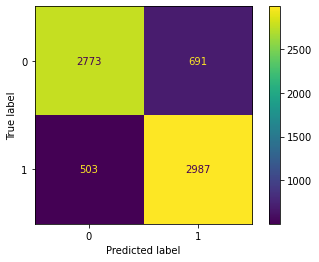

In [34]:
display_cm(clf_score["gradient_boosting_final"]["confusion_matrix"])

In [35]:
pd.DataFrame(clf_score).loc[["accuracy", "precision", "recall", "f1_score"],:]

,gradient_boosting_baseline,gradient_boosting_final
accuracy,0.81,0.828
precision,0.787,0.812
recall,0.852,0.856
f1_score,0.818,0.833


# Test score

In [36]:
# Load dataset
dataset_path = Path().absolute() / "data"
filename = "X_y_test.csv"
X_y_test = load_ds(dataset_path, filename)
print(f"Shape: {X_y_test.shape}")

Shape: (1739, 14)


In [37]:
# NOTE: "drop()" create a copy of the data original dataset
X_test = X_y_test.drop(["Transported"], axis=1)
y_test = X_y_test.loc[:, "Transported"].copy()

print(f"shape X_train: {X_test.shape}")
print(f"shape y_train: {y_test.shape}")

shape X_train: (1739, 13)
shape y_train: (1739,)


In [38]:
y_test_pred = clf_final.predict(X_test)

test_score = dict()

test_score = add_metrics(test_score, y_test, y_test_pred, "test_data")

In [39]:
(
    pd.DataFrame(test_score)
    .drop(labels="confusion_matrix", axis=0)
    .astype("float")
    .round(2)
)

,test_data
accuracy,0.82
f1_score,0.83
precision,0.81
recall,0.86


In [40]:
print_metrics(test_score["test_data"])

Accuracy is 0.82.
When the model claims a passenger was transported to another dimension, it is correct 80.7 % of the time (precision).
The model detects 85.70 % of the passengers that were transported to another dimension (recall).
The F1 score is 83.10.


# Test set (to submit)

In [41]:
# Load dataset
dataset_path = Path().absolute() / "data"
filename = "test.csv"
X_test_to_submit = load_ds(dataset_path, filename)
print(f"Shape: {X_test_to_submit.shape}")

Shape: (4277, 13)


In [42]:
y_test_to_submit = clf_final.predict(X_test_to_submit)

In [43]:
print(y_test_to_submit.shape)

(4277,)


In [44]:
df_to_csv = pd.DataFrame(data={
    "PassengerId":X_test_to_submit["PassengerId"],
    "Transported":np.array(y_test_to_submit, dtype='bool') })

In [45]:
df_to_csv.head(6)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,False


In [46]:
path_to_save = Path().absolute() / "submission" / "submission_xgboost.csv"
df_to_csv.to_csv(
    path_or_buf=path_to_save,
    index=False
)